# Plant Disease Detection - Deep Learning Project

## Initial Setup

In [1]:
# Imports
import torch
import torchvision
import matplotlib.pyplot as plt
import os
import requests
import zipfile
import shutil
import random
import importlib
import pandas as pd
import albumentations as A
import numpy as np

from tqdm.auto import tqdm
from torch import nn
from torchvision import transforms
from torch.utils.tensorboard import SummaryWriter
from typing import Dict, List
from albumentations.pytorch import ToTensorV2

try:
    from torchinfo import summary
except:
    ! pip install torchinfo
    from torchinfo import summary

try:
    import optuna
except:
    ! pip install optuna
    import optuna

try:
    import torcheval
except:
    ! pip install torcheval
    import torcheval

try:
    import helpers
except:
    print("[INFO] Couldn't find helpers modules fetching them from github.")
    !git clone https://github.com/othmane-mahfoud/plant-disease-detection.git
    !mv plant-disease-detection/helpers .
    !rm -rf plant-disease-detection
    import helpers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.1 MB/s eta 0:00:00
[INFO] Couldn't find helpers modules fetching them from github.
Cloning into 'plant-disease-detection'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 108 (delta 47), reused 96 (delta 35), pack-reused 0
Receiving objects: 100% (108/108), 13.03 MiB | 15.50 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [2]:
import helpers.setup
importlib.reload(helpers.setup)
from helpers.setup import set_device, set_seeds, set_pandas_options, reset_pandas_options

# Set the device
device = set_device()

# Set random seeds
set_seeds(seed=42, device=device)

# Pandas display setup to avoid truncation
set_pandas_options()
reset_pandas_options()

# Some running instructions
is_colab = True
is_experiment = False
is_optimization = False

### Setup Google Drive for Colab

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print("Not using collab")

Mounted at /content/drive


In [4]:
google_drive_dir = '/content/drive/MyDrive/plant-disease-detection/data'
local_data_dir = 'data'

## Data Acquisition

In [5]:
# import helpers.acquisition
# importlib.reload(helpers.acquisition)
# from helpers.acquisition import create_dataset, datasets_exist_in_drive, copy_datasets_from_drive

# url = "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded"

# if is_colab:
#     data_dir = google_drive_dir
# else:
#     data_dir = local_data_dir

# zip_path = os.path.join(data_dir, "data_compressed.zip")
# extracted_dir = "Plant_leave_diseases_dataset_without_augmentation"
# splits = {
#     'data_10_10_80': [0.1, 0.1, 0.8], #train 10% test 10% holdout 80%
#     'data_20_10_70': [0.2, 0.1, 0.7],
#     # 'data_30_10_60': [0.3, 0.1, 0.6],
#     'data_70_20_10': [0.7, 0.2, 0.1]
# }

# # Check if datasets exist in Google Drive
# if datasets_exist_in_drive(google_drive_dir, splits):
#     # Use paths from Google Drive
#     copy_datasets_from_drive(google_drive_dir, local_data_dir, splits)
#     data_paths = {split: os.path.join(google_drive_dir, split) for split in splits.keys()}
#     print("Dataset already available in Google Drive")
# else:
#     # Create datasets from scratch
#     create_dataset(url, zip_path, splits, data_dir, extracted_dir)
#     # Use local paths
#     data_paths = {split: os.path.join(data_dir, split) for split in splits.keys()}

In [8]:
# !rm -rf helpers
# !git clone https://github.com/othmane-mahfoud/plant-disease-detection.git
# !mv plant-disease-detection/helpers .
# !rm -rf plant-disease-detection
# import helpers

Cloning into 'plant-disease-detection'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (73/73), done.
remote: Total 111 (delta 49), reused 97 (delta 35), pack-reused 0
Receiving objects: 100% (111/111), 13.04 MiB | 12.35 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [9]:
import helpers.acquisition
importlib.reload(helpers.acquisition)
from helpers.acquisition import create_dataset

url = "https://data.mendeley.com/public-files/datasets/tywbtsjrjv/files/d5652a28-c1d8-4b76-97f3-72fb80f94efc/file_downloaded"
data_dir = "data"
zip_path = os.path.join(data_dir, "data_compressed.zip")
extracted_dir = "Plant_leave_diseases_dataset_without_augmentation"
splits = {
    'data_10_10_80': [0.1, 0.1, 0.8], #train 10% test 10% holdout 80%
    'data_20_10_70': [0.2, 0.1, 0.7],
    #'data_30_10_60': [0.3, 0.1, 0.6],
    'data_70_20_10': [0.7, 0.2, 0.1]
}

create_dataset(url, zip_path, splits, data_dir, extracted_dir)

Data folder already exists. Skipping download...
Nothing to extract. Skipping...
Dataset splits generated successfully!


## Data Exploration

In [10]:
import helpers.exploration
importlib.reload(helpers.exploration)
from helpers.exploration import traverse_dirs

data_dir_names = list(splits.keys())
classes_df = traverse_dirs(data_dir_names)
classes_df = classes_df.groupby(["dataset", "split_type", "class"]).sum()
classes_df

image_count
dataset       split_type class                                                     
data_10_10_80 holdout    Apple___Apple_scab                                     504
                         Apple___Black_rot                                      497
                         Apple___Cedar_apple_rust                               221
                         Apple___healthy                                       1317
                         Background_without_leaves                              915
...                                                                             ...
data_70_20_10 train      Tomato___Spider_mites Two-spotted_spider_mite         1173
                         Tomato___Target_Spot                                   982
                         Tomato___Tomato_Yellow_Leaf_Curl_Virus                3749
                         Tomato___Tomato_mosaic_virus                           261
                         Tomato___healthy                                      1113

[351 rows x 1 columns]

## Data Preparation and Augmentation

### Create Datasets and Dataloaders

In [11]:
import helpers.preparation
importlib.reload(helpers.preparation)
from helpers.preparation import create_dataloaders, display_img_grid, display_img_sample

BATCH_SIZE = 32
NUM_WORKERS = 1

train_dataloader_10_10_80_aug, test_dataloader_10_10_80 = create_dataloaders("data_10_10_80/train",
                                                                         "data_10_10_80/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="advanced"
                                                                        )

train_dataloader_10_10_80_cut, test_dataloader_10_10_80 = create_dataloaders("data_10_10_80/train",
                                                                         "data_10_10_80/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="cutmix"
                                                                        )

train_dataloader_10_10_80, test_dataloader_10_10_80 = create_dataloaders("data_10_10_80/train",
                                                                         "data_10_10_80/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="base"
                                                                        )

train_dataloader_20_10_70_aug, test_dataloader_20_10_70 = create_dataloaders("data_20_10_70/train",
                                                                         "data_20_10_70/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="advanced"
                                                                        )

train_dataloader_20_10_70_cut, test_dataloader_20_10_70 = create_dataloaders("data_20_10_70/train",
                                                                         "data_20_10_70/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="cutmix"
                                                                        )

train_dataloader_20_10_70, test_dataloader_20_10_70 = create_dataloaders("data_20_10_70/train",
                                                                         "data_20_10_70/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="base"
                                                                        )

train_dataloader_70_20_10_aug, test_dataloader_70_20_10 = create_dataloaders("data_70_20_10/train",
                                                                         "data_70_20_10/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="advanced"
                                                                        )

train_dataloader_70_20_10_cut, test_dataloader_70_20_10 = create_dataloaders("data_70_20_10/train",
                                                                         "data_70_20_10/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="cutmix"
                                                                        )

train_dataloader_70_20_10, test_dataloader_70_20_10 = create_dataloaders("data_70_20_10/train",
                                                                         "data_70_20_10/test",
                                                                         batch_size=BATCH_SIZE,
                                                                         num_workers=NUM_WORKERS,
                                                                         augmentation="base"
                                                                        )

### Display Sample Batches and Images

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


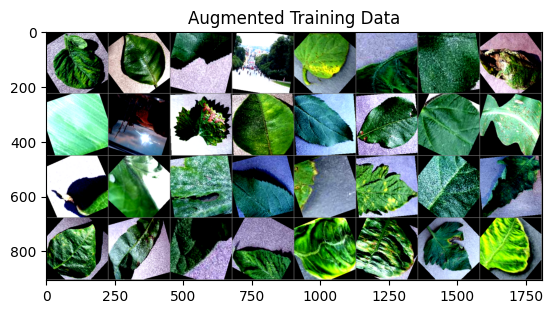

Tomato___Tomato_Yellow_Leaf_Curl_Virus
Orange___Haunglongbing_(Citrus_greening)
Apple___Black_rot
Background_without_leaves
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Apple___Black_rot
Potato___Late_blight
Corn___healthy
Background_without_leaves
Grape___Esca_(Black_Measles)
Orange___Haunglongbing_(Citrus_greening)
Apple___healthy
Apple___Black_rot
Soybean___healthy
Corn___Common_rust
Blueberry___healthy
Tomato___Late_blight
Squash___Powdery_mildew
Apple___healthy
Tomato___Bacterial_spot
Tomato___Leaf_Mold
Soybean___healthy
Tomato___Leaf_Mold
Pepper,_bell___Bacterial_spot
Peach___Bacterial_spot
Tomato___Target_Spot
Tomato___Spider_mites Two-spotted_spider_mite
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Pepper,_bell___Bacterial_spot
Tomato___Early_blight
Tomato___Tomato_Yellow_Leaf_Curl_Virus


In [12]:
display_img_grid(train_dataloader_10_10_80_aug, "Augmented Training Data")

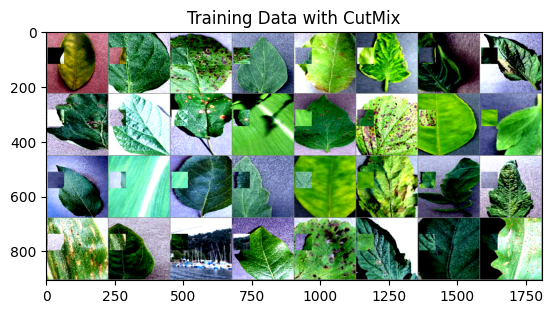

Orange___Haunglongbing_(Citrus_greening)
Pepper,_bell___healthy
Strawberry___Leaf_scorch
Tomato___healthy
Apple___Cedar_apple_rust
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Late_blight
Tomato___Target_Spot
Soybean___healthy
Apple___Black_rot
Corn___healthy
Tomato___Septoria_leaf_spot
Strawberry___Leaf_scorch
Orange___Haunglongbing_(Citrus_greening)
Tomato___Late_blight
Apple___healthy
Corn___healthy
Apple___healthy
Tomato___healthy
Orange___Haunglongbing_(Citrus_greening)
Tomato___Bacterial_spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Tomato___Spider_mites Two-spotted_spider_mite
Corn___Cercospora_leaf_spot Gray_leaf_spot
Tomato___Tomato_Yellow_Leaf_Curl_Virus
Background_without_leaves
Blueberry___healthy
Strawberry___Leaf_scorch
Tomato___Early_blight
Tomato___Bacterial_spot
Corn___Common_rust


In [13]:
display_img_grid(train_dataloader_10_10_80_cut, "Training Data with CutMix", is_cutmix=True)

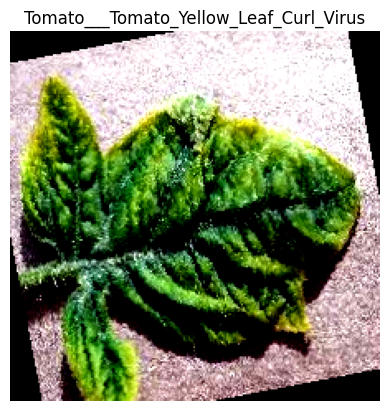

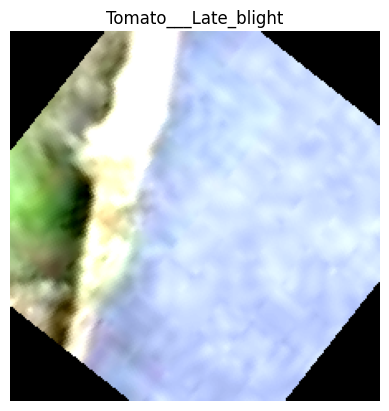

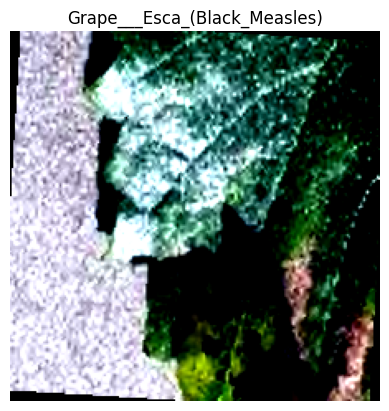

In [14]:
display_img_sample(train_dataloader_10_10_80_aug, "Sample Augmented Data with Labels", sample_size=3)

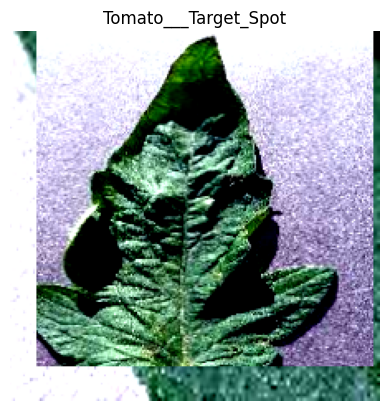

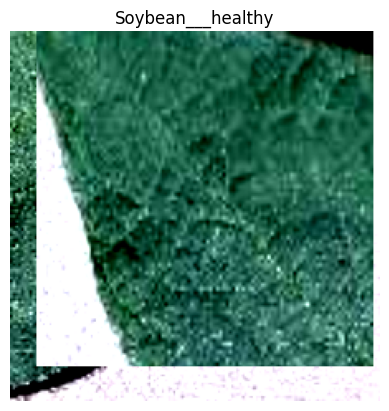

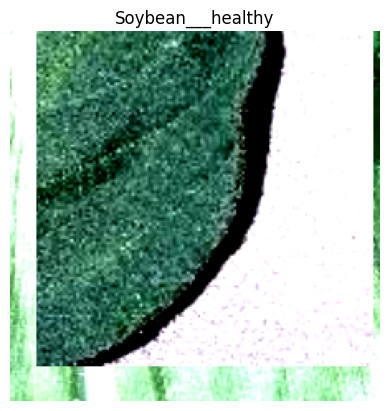

In [15]:
display_img_sample(train_dataloader_10_10_80_cut, "Sample Cutmix Data with Labels", is_cutmix=True, sample_size=3)

## Modeling

### Getting Pre-trained Models

In [16]:
import helpers.modeling
importlib.reload(helpers.modeling)
from helpers.modeling import create_effnetb0, create_vit, create_hybrid

# EfficientNetB0 - as the highest performing overall in Hassan et al. 99.56%
effnetb0_model = create_effnetb0(device, out_features=39)

# ViT - example of transformer based approach
vit_model = create_vit(device, out_features=39)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 178MB/s]


EffNetB0 model created successfully.


Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 220MB/s]


ViT model created successfully.


In [17]:
summary(model=effnetb0_model,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 39]             --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [18]:
summary(model=vit_model,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 39]             768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

### Create Base Model and Hybrid Model

---



In [19]:
import helpers.modeling
importlib.reload(helpers.modeling)
from helpers.modeling import create_effnetb0, create_vit, create_hybrid, create_base_model

hybrid_model = create_hybrid(device, out_features=39, dropout_proba=0.2)
input_tensor = torch.randn(1, 3, 224, 224)
output = hybrid_model(input_tensor)
print(output.shape)

Hybrid model created successfully.
torch.Size([1, 39])


In [20]:
dataiter = iter(train_dataloader_10_10_80)
images, labels = next(dataiter)
output = hybrid_model(images)
print(output.shape)
print(output)

torch.Size([32, 39])
tensor([[-4.0515e-02, -2.9284e-02,  7.7774e-03,  ..., -8.8922e-02,
         -4.8616e-02,  8.5186e-02],
        [-1.8038e-02, -1.0022e-02,  1.8489e-05,  ..., -4.9017e-02,
         -1.0169e-02,  1.1227e-01],
        [-1.7689e-02,  4.2369e-03,  4.0332e-03,  ..., -5.6393e-02,
         -1.9021e-02,  5.2085e-02],
        ...,
        [-5.7983e-02,  3.4973e-03,  1.7691e-02,  ..., -7.5782e-02,
         -6.3609e-02,  6.5531e-02],
        [-3.1298e-02,  8.5137e-03, -7.0259e-03,  ..., -7.1812e-02,
         -1.6859e-02,  7.1202e-02],
        [-6.7120e-02, -8.7130e-03, -2.9530e-03,  ..., -3.5522e-02,
         -2.8363e-02,  7.6261e-02]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [21]:
summary(model=hybrid_model,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, color_channels, height, width)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        device=device)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
HybridModel (HybridModel)                [32, 3, 224, 224]    [32, 39]             --                   True
├─ConvBlock (conv1)                      [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    └─Conv2d (conv)                     [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    └─BatchNorm2d (bn)                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    └─SiLU (activation)                 [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
├─ConvBlock (conv2)                      [32, 32, 112, 112]   [32, 64, 56, 56]     --                   True
│    └─Conv2d (conv)                     [32, 32, 112, 112]   [32, 64, 56, 56]     18,432               True
│    └─BatchNorm2d (bn)                  [32, 64, 56, 56]     [32, 64, 56, 56]     128                  True
│    └─SiLU (act

## Model Training and Experiment Tracking

### Setup for experiment tracking

In [22]:
# epoch list
num_epochs = [5, 10]

# models dictionary
models_dict = {
    "hybrid": create_hybrid,
    "effnetb0": create_effnetb0,
    "vit": create_vit,
}

# dataloaders dictionary
dataloaders_dict = {
    "data_10_10_80_cut": (train_dataloader_10_10_80_cut, test_dataloader_10_10_80),
    "data_10_10_80_aug": (train_dataloader_10_10_80_aug, test_dataloader_10_10_80),
    "data_10_10_80": (train_dataloader_10_10_80, test_dataloader_10_10_80),
    "data_20_10_70_cut": (train_dataloader_20_10_70_cut, test_dataloader_20_10_70),
    "data_20_10_70_aug": (train_dataloader_20_10_70_aug, test_dataloader_20_10_70),
    "data_20_10_70": (train_dataloader_20_10_70, test_dataloader_20_10_70),
}

In [23]:
if is_experiment:

    import helpers.training
    importlib.reload(helpers.training)
    from helpers.training import train, cross_entropy_one_hot

    import helpers.utils
    importlib.reload(helpers.utils)
    from helpers.utils import save_model, create_writer

    set_seeds(seed=42, device=device)

    experiment_number = 0

    for dataloader_name, (train_dataloader, test_dataloader) in dataloaders_dict.items():
        # loop through epochs
        for epochs in num_epochs:
            # loop through models we want to experiment
            for model_name, create_model in models_dict.items():
                experiment_number += 1
                print(f"Experiment Number: {experiment_number}")
                print(f"Model:{model_name}")
                print(f"DataLoader:{dataloader_name}")
                print(f"Number of epochs:{epochs}")

                # create a model instance
                model = create_model(device, out_features=39)

                #if dataloader_name.split("_")[-1] == "cut":
                #    loss_fn = cross_entropy_one_hot
                #else:
                #    loss_fn = nn.CrossEntropyLoss()

                loss_fn = nn.CrossEntropyLoss()

                optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001, weight_decay=0.0001) # trying weight decay

                writer_local, writer_drive = create_writer(
                    experiment_name=dataloader_name,
                    model_name=model_name,
                    extra=f"{epochs}_epochs"
                )

                # train the model
                train(
                    model=model,
                    train_dataloader=train_dataloader,
                    test_dataloader=test_dataloader,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    epochs=epochs,
                    device=device,
                    writer=create_writer(
                        experiment_name=dataloader_name,
                        model_name=model_name,
                        extra=f"{epochs}_epochs"
                    )
                )
                # save the model to a file so we can import the best one later
                save_filepath = f"{model_name}_{dataloader_name}_{epochs}_epochs.pth"
                save_model(
                    model=model,
                    target_dir="models",
                    model_name=save_filepath
                )
                print("-"*50 + "\n")

In [24]:
if is_experiment:
    %load_ext tensorboard
    %tensorboard --logdir runs

## Model Selection and Improvement

Improve model with most promising data augmentation technique

Add learning rate scheduler : https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate

Try weight decay: https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab

Optimize it using optuna

In [25]:
if is_optimization:
    try:
        import optuna
    except:
        ! pip install optuna
        import optuna

    try:
        import torcheval
    except:
        ! pip install torcheval

    import helpers.optimization
    importlib.reload(helpers.optimization)
    from helpers.optimization import objective

    # Create Optuna study
    study = optuna.create_study(direction='maximize')

    # Optimize the objective function with data loaders
    study.optimize(lambda trial: objective(trial, train_dataloader_10_10_80, test_dataloader_10_10_80), n_trials=10)

    print(f"Best trial: {study.best_trial.number}")
    print(f"Best value (validation accuracy): {study.best_trial.value}")
    print("Best hyperparameters: ", study.best_trial.params)

## Selected Model Training

- Train it on 70% train 20% test 10% holdout (either GAN or no GAN depending on which performed better)

- Calculate accuracy, precision, recall for the model (+ confusion matrix?)

- Save the model

Best hyperparameters:  {'optimizer': 'Adam', 'lr': 0.0003485693018996268, 'dropout_proba': 0.32379270573399566}

In [29]:
import helpers.setup
importlib.reload(helpers.setup)
from helpers.setup import set_device, set_seeds

import helpers.training
importlib.reload(helpers.training)
from helpers.training import train

import helpers.modeling
importlib.reload(helpers.modeling)
from helpers.modeling import create_hybrid

import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

device = set_device()
set_seeds(42, device)

# Hyperparameters from Optuna
lr = 0.0003485693018996268
dropout_proba = 0.32379270573399566

# Create model
model = create_hybrid(device=device, out_features=39, dropout_proba=dropout_proba)

# Create optimizer based on optuna results
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.0001)

# Setup LR scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Train the model
results = train(
    model=model,
    train_dataloader=train_dataloader_70_20_10,
    test_dataloader=test_dataloader_70_20_10,
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=100,
    device=device,
    writer_local=None,
    writer_drive=None,
    scheduler=scheduler
)

# Save the model
save_model(model, "models", f"HybridModel_Optimized.pth")

Hybrid model created successfully.


  0%|          | 0/100 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


epoch: 1 | train loss: 1.5329 | train accuracy: 0.5645 | test loss: 1.0171 | test accuracy: 0.7043
epoch: 2 | train loss: 0.8633 | train accuracy: 0.7414 | test loss: 0.6101 | test accuracy: 0.8157
epoch: 3 | train loss: 0.6275 | train accuracy: 0.8099 | test loss: 0.5578 | test accuracy: 0.8288
epoch: 4 | train loss: 0.5373 | train accuracy: 0.8370 | test loss: 0.4971 | test accuracy: 0.8501
epoch: 5 | train loss: 0.4704 | train accuracy: 0.8573 | test loss: 0.3892 | test accuracy: 0.8813
epoch: 6 | train loss: 0.4336 | train accuracy: 0.8665 | test loss: 0.4237 | test accuracy: 0.8689
epoch: 7 | train loss: 0.4017 | train accuracy: 0.8774 | test loss: 0.3684 | test accuracy: 0.8882
epoch: 8 | train loss: 0.3676 | train accuracy: 0.8872 | test loss: 0.3200 | test accuracy: 0.9035
epoch: 9 | train loss: 0.3446 | train accuracy: 0.8939 | test loss: 0.2751 | test accuracy: 0.9175
epoch: 10 | train loss: 0.3238 | train accuracy: 0.9007 | test loss: 0.3501 | test accuracy: 0.8947
epoch: 11

NameError: name 'save_model' is not defined

## Make Predictions

In [ ]:
# Predict on test set and display

# Predict on holdout set and display

## Model Deployment

In [ ]:
# Deploy the model using Gradio

# THE END